## Import Required Packages

In [10]:
# import modules
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt

from kdg.kdn import *
from kdg.utils import gaussian_sparse_parity, trunk_sim
from functions.weighted_kdn_tutorialfunctions import *

## Prepare dataset (Gaussian Sparse Parity)

In [18]:
# Define the experimental setup.
# We will be using a Gaussian sparse parity setup
# You can change these parameters.
# Higher than 10,000 training samples will take a prohibitively long time to run

p = 20  # total dimensions of the data vector
p_star = 3  # number of signal dimensions of the data vector

n_train = 2000
n_test = 1000

X, y = gaussian_sparse_parity(n_train, p_star=p_star, p=p)
X_test, y_test = gaussian_sparse_parity(n_test, p_star=p_star, p=p)

## Raw Neural Network

In [19]:
# Define our neural network parameters
dense_layer_nodes = 5

# NN params
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
fit_kwargs = {"epochs": 150, "batch_size": 32, "verbose": False}


# Fit the neural network using our test data and print accuracy
raw_nn = getNN(dense_layer_nodes, p, **compile_kwargs)
raw_nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
y_hat = np.argmax(raw_nn.predict(X_test), axis=1)

print(f"Raw NN Accuracy: {np.mean(y_hat == y_test)}")

Raw NN Accuracy: 0.614


## Kernel Density Network

The goal of the kernel density network algorithm (KDN) is to reduce the overhead of a traditional neural network by using the neural network to fit Gaussian distributions to the polytope space. We will define polytopes by the nodes activated when data is passed through the neural network. Then subsequent data is classified according to the class of the polytope it most closely matches.

Number of Polytopes :  983
Number of Unique Polytopes :  142


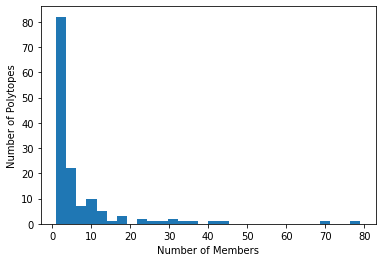

Number of Polytopes :  1017
Number of Unique Polytopes :  158


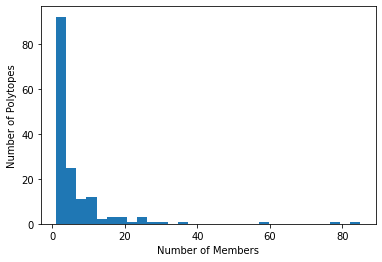

Unweighted KDN Accuracy: 0.632


In [20]:
# Initialize KDN using previous neural network
unweighted_kdn = kdn(network=raw_nn, weighted=False, verbose=True)
unweighted_kdn.fit(X, y)

y_hat = unweighted_kdn.predict(X_test)

print(f"Unweighted KDN Accuracy: {np.mean(y_hat == y_test)}")

## Weighted Kernel Density Network


Neural networks are stochastic: two identical data samples should be processed by a neural network in an identical manner, activating the same nodes in each layer. This means one possible metric of similarity between two samples would be to compare the neural network activation pattern at each layer.

Given that if a layer is significantly different, that difference will propagate through all subsequent layers, we iterate through the neural network one layer at a time, drawing nodes one at a time until a mismatched node is found.

Let $N$ be the number of nodes in the network, $n$ be the number of nodes in a single layer of the network, and $m$ be the number of matches in a given layer, $(n \leq N, m \leq n)$.

The probability of drawing exactly $k$ matched nodes, followed by a single mismatched node is:

\begin{align}P(k) = \frac{1}{k+1} \frac{{m \choose k}{n-m \choose 1}}{{n \choose k+1}}\end{align}

i.e. the probability of drawing exactly $k$ matches and 1 mismatch, in that specific order.

Then for each layer, we can calculate the expected weight, $E(W_i)$, by multiplying each weight $\frac{k}{n}$ by the probability that exactly $k$ nodes will be drawn and adding them together:

\begin{align}
E(W_i) & = \sum_{k=0}^{m} \frac{k}{n}\frac{1}{k+1} \frac{{m \choose k}{n-m \choose 1}}{{n \choose k+1}}\\
& = \sum_{k=0}^{m} \frac{k}{n(k+1)} \frac{{m \choose k}(n-m)}{{n \choose k+1}}\\
&....\\
& = \frac{1}{n-m+1}\frac{{n-1 \choose n-m}}{{n \choose n-m}}\\
& = \frac{1}{n-m+1}\frac{(n-1)!m!}{n!(m-1)!}\\
& = \frac{m}{n(n-m+1)}\\
\end{align}

Test the function below to confirm:

In [21]:
reps = 10
N = np.random.randint(5, 100, reps)
M = [np.random.randint(n) for n in N]

test = np.vstack((N, M))

for t in test.T:
    print(
        f"(n={t[0]}, m={t[1]}), Hypergeometric Weight: {hypergeom_weight(t[0], t[1])}, Simplified Weight: {simple_weight(t[0], t[1])}"
    )


(n=21, m=4), Hypergeometric Weight: 0.010582010582010581, Simplified Weight: 0.010582010582010581
(n=51, m=43), Hypergeometric Weight: 0.09368191721132894, Simplified Weight: 0.09368191721132897
(n=44, m=23), Hypergeometric Weight: 0.0237603305785124, Simplified Weight: 0.023760330578512397
(n=29, m=12), Hypergeometric Weight: 0.02298850574712644, Simplified Weight: 0.022988505747126436
(n=63, m=35), Hypergeometric Weight: 0.019157088122605363, Simplified Weight: 0.019157088122605363
(n=40, m=5), Hypergeometric Weight: 0.003472222222222222, Simplified Weight: 0.003472222222222222
(n=40, m=19), Hypergeometric Weight: 0.0215909090909091, Simplified Weight: 0.02159090909090909
(n=21, m=3), Hypergeometric Weight: 0.007518796992481202, Simplified Weight: 0.007518796992481203
(n=53, m=15), Hypergeometric Weight: 0.007256894049346881, Simplified Weight: 0.00725689404934688
(n=58, m=40), Hypergeometric Weight: 0.03629764065335753, Simplified Weight: 0.036297640653357534


However, for 2 unrelated binary strings, the expected number of mismatches, i.e. the Hamming distance goes towards $\frac{n}{2}$. Note that looking at ${n \choose k}$, this value is largest when $k = \frac{n}{2}$. If we only set $E(W_i) = 0$ when a perfect mismatch occurs, then we would expect almost every layer of sufficient size to have a match, and every network to match somewhere along its activation path.

For example, given a neural network of size $(5,5,2)$, the odds a random activation path has zero matches are $2^{-12} = 2.44 \times 10^{-4}$. This scales prohibitively with the size of the network, and requires setting a floor at $m \geq \frac{n}{N}$. If $m$ is below this floor, set $E(W_i) = 0$.

However, this means our minimum weight for a given layer is now:
$$E(W_i)=\frac{n}{2n(n-\frac{n}{2}+1)}=\frac{1}{2n-n+2}=\frac{1}{n+2}$$

To make use of the full weighting space, we want to scale our weights from 0 to 1, both within this layer (eliminating the floor) as well as within the entire network. The size of a single layer within the larger network is $\frac{n}{N}$.

Therefore, our final weighting formula is:
\begin{align}
E(W_i) & = \frac{n}{N}\frac{2(m-\frac{n}{2})}{n(n-m+1)} \\
& = \frac{2m-n}{N(n-m+1)}, \forall \frac{n}{2} < m \leq n
\end{align}

Since if $m = \frac{n}{2}$, $E(W_i) = 0$, we can skip the calculation in this instance. Compare the improvement versus the unweighted algorithm and the change in polytope membership.

Number of Polytopes :  983
Number of Unique Polytopes :  142


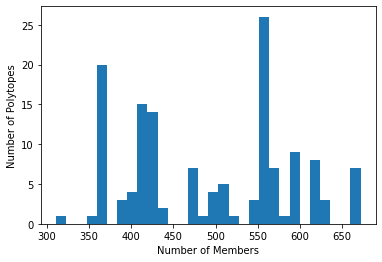

Number of Polytopes :  1017
Number of Unique Polytopes :  158


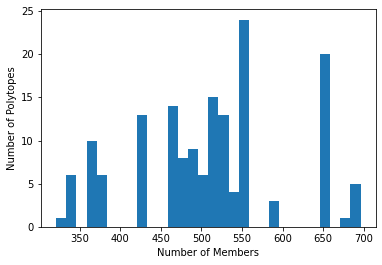

Weighted KDN Accuracy: 0.668


In [22]:
# Initialize KDN using previous neural network
weighted_kdn = kdn(network=raw_nn, weighted=True, verbose=True)
weighted_kdn.fit(X, y)

y_hat = weighted_kdn.predict(X_test)

print(f"Weighted KDN Accuracy: {np.mean(y_hat == y_test)}")

## Mean Accuracy

To validate the efficacy of our algorithm, we will test it on a variety of sample sizes. As the runtime can be prohibitive, a smaller set of points will be used. The larger dataset is also included (runtime ~5 hours).

Testing with 1000 samples
NN Accuracy: [0.517, 0.494, 0.541, 0.515, 0.486]
KDN-Unweighted Accuracy: [0.55, 0.528, 0.587, 0.567, 0.544]
KDN-Weighted Accuracy: [0.534, 0.5, 0.572, 0.528, 0.537]
Testing with 2000 samples
NN Accuracy: [0.829, 0.719, 0.504, 0.805, 0.682]
KDN-Unweighted Accuracy: [0.648, 0.693, 0.566, 0.628, 0.665]
KDN-Weighted Accuracy: [0.707, 0.725, 0.538, 0.702, 0.678]
Testing with 5000 samples
NN Accuracy: [0.888, 0.801, 0.867, 0.868, 0.925]
KDN-Unweighted Accuracy: [0.718, 0.695, 0.711, 0.729, 0.71]
KDN-Weighted Accuracy: [0.845, 0.818, 0.87, 0.836, 0.846]
Testing with 10000 samples
NN Accuracy: [0.873, 0.922, 0.939, 0.916, 0.883]
KDN-Unweighted Accuracy: [0.822, 0.77, 0.756, 0.744, 0.785]
KDN-Weighted Accuracy: [0.882, 0.906, 0.9, 0.881, 0.874]


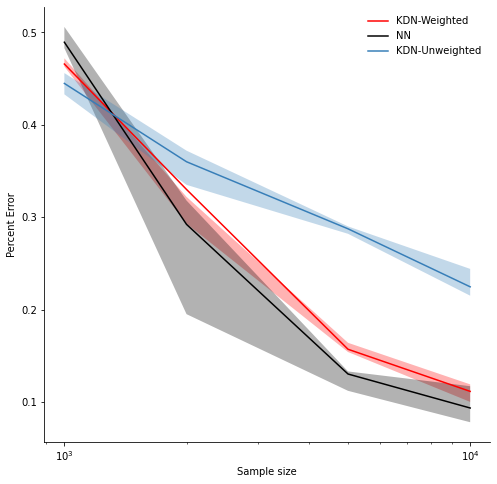

In [26]:
accuracy_nn = []
accuracy_kdn = []
accuracy_weighted = []

sample_size = [1000, 2000, 5000, 10000]
reps = 5

# Full dataset
# sample_size = [1000, 2000, 5000, 10000, 20000, 30000, 50000]
# reps = 10

test_size = min(sample_size)

# Run tests
for s in sample_size:
    print(f"Testing with {s} samples")
    for r in range(reps):
        X, y = gaussian_sparse_parity(s, p_star=p_star, p=p)
        X_test, y_test = gaussian_sparse_parity(test_size, p_star=p_star, p=p)

        raw_nn = getNN(dense_layer_nodes, p, **compile_kwargs)
        raw_nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

        accuracy_nn.append(np.mean(np.argmax(raw_nn.predict(X_test), axis=1) == y_test))

        unweighted_kdn = kdn(network=raw_nn, weighted=False, verbose=False)
        unweighted_kdn.fit(X, y)

        accuracy_kdn.append(np.mean(unweighted_kdn.predict(X_test) == y_test))

        weighted_kdn = kdn(network=raw_nn, weighted=True, verbose=False)
        weighted_kdn.fit(X, y)

        accuracy_weighted.append(np.mean(weighted_kdn.predict(X_test) == y_test))
    print("NN Accuracy:", accuracy_nn[-reps:])
    print("KDN-Unweighted Accuracy:", accuracy_kdn[-reps:])
    print("KDN-Weighted Accuracy:", accuracy_weighted[-reps:])

# Plot results
shape = (len(sample_size), reps)
err_nn = 1 - np.array(accuracy_nn).reshape(shape)
err_kdn = 1 - np.array(accuracy_kdn).reshape(shape)
err_weighted = 1 - np.array(accuracy_weighted).reshape(shape)

error_rates = (err_weighted, err_nn, err_kdn)
labels = ("KDN-Weighted", "NN", "KDN-Unweighted")

plot_accuracy(sample_size, error_rates, labels)